# Deep Learning Training with NEC Constraints

**Features:**
1. NEC (Null Energy Condition) constraint enforcement
2. **Optimize all parameters**: a, b, coef, and shift (LS provides initialization only)
3. Nonzero constraints on a/b to ensure swallowtail formation
4. **Parameter bounds: a, b ∈ [-1.0, 1.0]** (tight bounds prevent L_max from growing too large)
5. Coverage penalty encourages swallowtail to span data range

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from dataset_HR import AdSBHDataset
from model_HR_new import AdSBHNet
from constants import dreal, dcomplex

## 1. Load Data

Dataset: 15 points
Train: 12, Val: 3
L range: [0.1538, 1.3306]


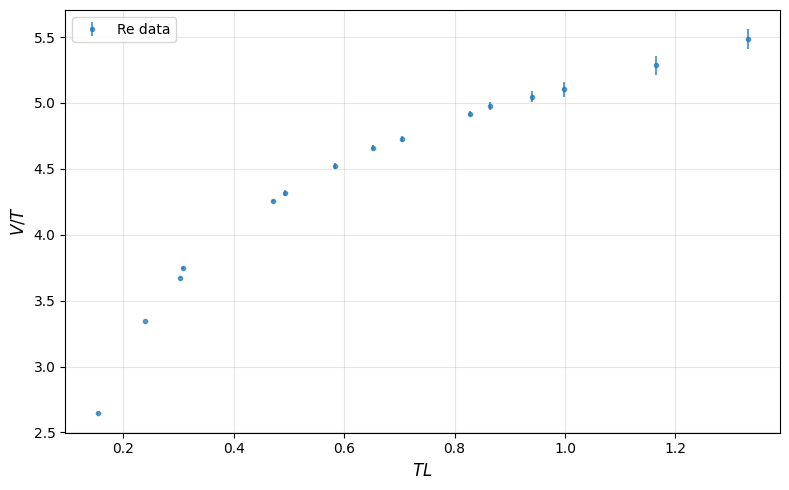

In [2]:
dataset = AdSBHDataset(file='1607latticeT338.txt')

# Filter data
mask_L = dataset.L < 1.4
L_all = dataset.L[mask_L]
V_all = dataset.V[mask_L]
sigma_all = dataset.sigma[mask_L]

# Train/val split (80/20)
N = len(L_all)
idx = torch.randperm(N)
n_train = int(0.8 * N)
train_idx = idx[:n_train]
val_idx = idx[n_train:]

L_train, V_train, sigma_train = L_all[train_idx], V_all[train_idx], sigma_all[train_idx]
L_val, V_val, sigma_val = L_all[val_idx], V_all[val_idx], sigma_all[val_idx]

print(f"Dataset: {len(L_all)} points")
print(f"Train: {len(L_train)}, Val: {len(L_val)}")
print(f"L range: [{L_all.min():.4f}, {L_all.max():.4f}]")

plt.figure(figsize=(8, 5))
plt.errorbar(L_all.numpy(), V_all.real.numpy(), yerr=sigma_all.real.numpy(), 
             fmt='.', label='Re data', alpha=0.7)
plt.xlabel(r'$T L$', fontsize=12)
plt.ylabel(r'$V/T$', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Initialize Model

In [3]:
N_COEFFS = 4
model = AdSBHNet(N=N_COEFFS, std=0.1)
device = model.a.device
dt = model.a.dtype

# Move data to device
L_all = L_all.to(device=device, dtype=dt)
V_all = V_all.to(device=device)
sigma_all = sigma_all.to(device=device)
L_train = L_train.to(device=device, dtype=dt)
V_train = V_train.to(device=device)
sigma_train = sigma_train.to(device=device)
L_val = L_val.to(device=device, dtype=dt)
V_val = V_val.to(device=device)
sigma_val = sigma_val.to(device=device)

# Initialize a and b to reasonable starting values
# Start small to avoid L_max being too large
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    model.a[0] = -0.25
    model.b[0] = 0.25
    
    if model.a.numel() > 1:
        model.a[1:] = torch.tensor([0.26, 0.31, 0.33], dtype=dt, device=device)
        model.b[1:] = torch.tensor([0.12, 0.12, 0.13], dtype=dt, device=device)

print("Initial parameters:")
print(f"  a = {model.a.detach().cpu().numpy()}")
print(f"  b = {model.b.detach().cpu().numpy()}")

Initial parameters:
  a = [-0.25  0.26  0.31  0.33]
  b = [0.25 0.12 0.12 0.13]


## 3. Helper Functions

In [4]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=3000):
    """Extract the real connected branch of the swallowtail."""
    dev, dtype = model.a.device, model.a.dtype
    zs = torch.linspace(zmin, zmax, Nc, dtype=dtype, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


def interp_1d(x, y, xq, eps=1e-12):
    """1D linear interpolation with extrapolation."""
    if x.numel() < 2:
        return torch.full_like(xq, y[0] if y.numel() > 0 else 0.0)
    
    xq = torch.as_tensor(xq, dtype=x.dtype, device=x.device).reshape(-1)
    pos = torch.searchsorted(x, xq, right=True)
    i0 = (pos - 1).clamp(0, x.numel() - 2)
    i1 = i0 + 1
    
    x0, x1 = x[i0], x[i1]
    y0, y1 = y[i0], y[i1]
    w = (xq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w * (y1 - y0)
    
    # Extrapolation
    mL = (y[1] - y[0]) / (x[1] - x[0] + eps)
    mR = (y[-1] - y[-2]) / (x[-1] - x[-2] + eps)
    v_left = y[0] + mL * (xq - x[0])
    v_right = y[-1] + mR * (xq - x[-1])
    
    v = torch.where(xq < x[0], v_left, v_lin)
    v = torch.where(xq > x[-1], v_right, v)
    return v


def nec_penalty(a, b, num_samples=100):
    """
    Compute NEC (Null Energy Condition) violation penalty.
    
    NEC requires: -(3/2z) * [a'(z) + b'(z)] >= 0 for all z in [0, 1]
    This means: (a0+b0) + 2(a1+b1)z + 3(a2+b2)z^2 + 4(a3+b3)z^3 <= 0
    
    We penalize violations where P(z) > 0.
    """
    dev, dtype = a.device, a.dtype
    z = torch.linspace(0.01, 0.99, num_samples, dtype=dtype, device=dev)
    
    # Compute polynomial P(z) = sum (n+1)(an+bn)z^n
    P = (a[0] + b[0]) + 2*(a[1] + b[1])*z + 3*(a[2] + b[2])*z**2 + 4*(a[3] + b[3])*z**3
    
    # NEC violation if P > 0
    violation = torch.relu(P).max()
    
    return violation


@torch.no_grad()
def enforce_constraints(model, min_mag=0.15, a_min=-1.0, a_max=1.0, b_min=-1.0, b_max=1.0):
    """
    Enforce all parameter constraints:
    - a[0] = -b[0] with |a[0]| >= min_mag
    - a[0] must be negative (in range [a_min, -min_mag])
    - All a coefficients in [a_min, a_max]
    - All b coefficients in [b_min, b_max]
    
    Note: Tighter bounds [-1, 1] are essential because larger norms lead to 
    larger L_max, pushing the swallowtail beyond the data range.
    """
    # Clamp all a and b to valid ranges
    model.a.clamp_(a_min, a_max)
    model.b.clamp_(b_min, b_max)
    
    # Enforce a[0] = -b[0] with minimum magnitude
    a0_raw = model.a[0]
    mag = torch.clamp(a0_raw.abs(), min=min_mag)
    a0 = -mag
    
    # Keep a[0] in valid range
    a0 = torch.clamp(a0, a_min, -min_mag)
    
    model.a[0].copy_(a0)
    model.b[0].copy_(-a0)
    
    return float(a0.item())


def smoothness_C2(val_fn, z):
    """Compute C2 smoothness penalty."""
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()


def uv_horizon_penalty(model):
    """Penalize UV and horizon boundary conditions."""
    z0 = torch.tensor(1e-3, dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995, dtype=model.a.dtype, device=model.a.device)
    
    f0 = model.eval_f(z0)
    g0 = model.eval_g(z0)
    fhor = model.eval_f(zh)
    
    def _r2(t, target):
        if torch.is_complex(t):
            return (t.real - target)**2 + t.imag**2
        else:
            return (t - target)**2
    
    return _r2(f0, 1.0) + _r2(g0, 1.0) + _r2(fhor, 0.0)

## 4. LS Initialization for coef and shift

In [5]:
with torch.no_grad():
    Lm, Vm = connected_branch(model)
    
    if Lm.numel() >= 2:
        mask = (L_train >= Lm[0]) & (L_train <= Lm[-1])
        if mask.sum() >= 3:
            L_fit = L_train[mask]
            V_fit = V_train.real[mask]
            X_fit = interp_1d(Lm, Vm, L_fit)
            
            X_np = X_fit.cpu().numpy().reshape(-1, 1)
            Y_np = V_fit.cpu().numpy()
            
            reg = LinearRegression().fit(X_np, Y_np)
            coef = max(float(reg.coef_[0]), 1e-6)
            shift = float(reg.intercept_)
            
            model.logcoef.copy_(torch.tensor(np.log(coef), dtype=dt, device=device))
            model.shift.copy_(torch.tensor(shift, dtype=dt, device=device))

print(f"LS init: coef={np.exp(float(model.logcoef.detach())):.6f}, shift={float(model.shift.detach()):.6f}")
print(f"Initial swallowtail at L_max = {Lm[-1].item():.4f}")

LS init: coef=0.253000, shift=4.560628
Initial swallowtail at L_max = 0.4722


## 5. Loss Function with NEC and Swallowtail Constraints

In [6]:
def compute_loss(
    model, 
    L_batch, 
    V_batch, 
    sigma_batch,
    lam_nec=50.0,
    lam_a_L2=1e-5,
    lam_b_L2=1e-5,
    lam_a_C2=1e-5,
    lam_b_C2=1e-5,
    lam_phy=1e-4,
    lam_nonzero=10.0
):
    """
    Compute loss with NEC constraint (swallowtail L_max constraint removed).
    
    Args:
        lam_nec: Weight for NEC penalty
        lam_nonzero: Penalty to keep a,b nonzero
    """
    eps = 1e-12
    dev, dtype = model.a.device, model.a.dtype
    
    L_batch = L_batch.to(dev, dtype)
    V_batch = V_batch.to(dev)
    sigma_batch = sigma_batch.to(dev)
    
    # Get model prediction on real branch
    try:
        Lm, Vm = connected_branch(model)
    except:
        return torch.tensor(1e10, device=dev), {}
    
    if Lm.numel() < 5 or not torch.isfinite(Lm).all() or not torch.isfinite(Vm).all():
        return torch.tensor(1e10, device=dev), {}
    
    # Swallowtail L_max (just for reporting, no penalty)
    Lmax_model = Lm[-1]
    
    # NEC penalty
    nec_viol = nec_penalty(model.a, model.b, num_samples=100)
    nec_penalty_value = lam_nec * nec_viol
    
    # Data fitting
    mask = (L_batch >= Lm[0]) & (L_batch <= Lm[-1])
    if mask.sum() < 3:
        # Insufficient coverage - use softer penalty to allow gradients
        coverage_penalty = 100.0
        chi2_data = torch.tensor(100.0, device=dev)
    else:
        V_model = interp_1d(Lm, Vm, L_batch[mask]) * torch.exp(model.logcoef) + model.shift
        residuals = V_model - V_batch.real[mask]
        
        w_stat = 1.0 / (sigma_batch.real[mask]**2 + eps)
        L_weight = (L_batch[mask] / L_batch.max()).clamp_min(0).pow(2.0)
        w_total = w_stat * L_weight
        
        chi2_data = (w_total * residuals**2).mean()
        
        # Coverage penalty - encourage covering all data
        Lmax_data = L_batch.max()
        if Lmax_model < Lmax_data:
            gap = (Lmax_data - Lmax_model) / Lmax_data.clamp_min(1e-6)
            coverage_penalty = 10.0 * (gap**2)
        else:
            coverage_penalty = 0.0
    
    # Regularization
    z_reg = torch.linspace(1e-3, 0.99, 220, dtype=dtype, device=dev)
    reg_L2 = lam_a_L2 * (model.a.real**2).sum() + lam_b_L2 * (model.b.real**2).sum()
    reg_C2 = lam_a_C2 * smoothness_C2(model.eval_a, z_reg) + lam_b_C2 * smoothness_C2(model.eval_b, z_reg)
    reg_phy = lam_phy * uv_horizon_penalty(model)
    
    # Nonzero penalty (ensure a and b don't collapse to zero)
    nonzero_penalty = lam_nonzero * (torch.exp(-model.a[1:].abs().sum()) + torch.exp(-model.b[1:].abs().sum()))
    
    # Total loss (NO swallowtail penalty)
    total_loss = chi2_data + reg_L2 + reg_C2 + reg_phy + coverage_penalty + nec_penalty_value + nonzero_penalty
    
    if not torch.isfinite(total_loss):
        total_loss = torch.tensor(1e10, device=dev)
    
    components = {
        'chi2_data': chi2_data.detach() if torch.is_tensor(chi2_data) else chi2_data,
        'reg_L2': reg_L2.detach(),
        'reg_C2': reg_C2.detach(),
        'reg_phy': reg_phy.detach(),
        'coverage_penalty': coverage_penalty,
        'nec_penalty': nec_penalty_value.detach(),
        'nec_violation': nec_viol.detach(),
        'nonzero_penalty': nonzero_penalty.detach(),
        'Lmax_model': float(Lmax_model.item()),
        'coverage': int(mask.sum().item())
    }
    
    return total_loss, components


## 6. Training: Optimize all parameters (a, b, coef, shift)

In [7]:
# Single-stage training: Optimize ALL parameters (a, b, coef, shift)
model.logcoef.requires_grad = True  # CHANGED: now trainable
model.shift.requires_grad = True     # CHANGED: now trainable

print("\n" + "="*70)
print("TRAINING: Optimizing a, b, coef, and shift")
print("  Initial coef={:.6f}, shift={:.4f}".format(
    np.exp(float(model.logcoef.detach())), float(model.shift.detach())))
print("="*70 + "\n")

# Optimizer - train all parameters
opt = torch.optim.AdamW([
    {'params': [model.a], 'lr': 1e-3, 'weight_decay': 0.0},
    {'params': [model.b], 'lr': 1e-3, 'weight_decay': 0.0},
    {'params': [model.logcoef], 'lr': 5e-4, 'weight_decay': 0.0},  # Smaller LR for coef
    {'params': [model.shift], 'lr': 1e-3, 'weight_decay': 0.0},
], betas=(0.9, 0.999))

EPOCHS = 500
a_hist, b_hist = [], []
train_loss_hist, val_loss_hist = [], []
lmax_hist = []
coef_hist, shift_hist = [], []

# Training loop
train_ds = torch.utils.data.TensorDataset(L_train, V_train, sigma_train)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n_batches = 0
    
    for L_batch, V_batch, sigma_batch in train_loader:
        opt.zero_grad()
        
        loss, info = compute_loss(model, L_batch, V_batch, sigma_batch)
        
        if not torch.isfinite(loss):
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        
        # Enforce constraints: [-1, 1] bounds on a and b
        with torch.no_grad():
            enforce_constraints(model, min_mag=0.15, a_min=-1.0, a_max=1.0, b_min=-1.0, b_max=1.0)
        
        running_loss += float(loss.item())
        n_batches += 1
    
    train_loss = running_loss / max(n_batches, 1)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss, val_info = compute_loss(model, L_val, V_val, sigma_val)
        val_loss = float(val_loss.item())
    
    # Record history
    a_hist.append(model.a.detach().cpu().numpy().copy())
    b_hist.append(model.b.detach().cpu().numpy().copy())
    coef_hist.append(np.exp(float(model.logcoef.detach())))
    shift_hist.append(float(model.shift.detach()))
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    lmax_hist.append(info.get('Lmax_model', 0.0))
    
    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"loss={train_loss:.4e} | val={val_loss:.4e} | "
              f"L_max={info['Lmax_model']:.4f} | NEC={info['nec_violation']:.2e} | "
              f"cov={info['coverage']} | coef={np.exp(float(model.logcoef.detach())):.4f}")

print("\nTraining complete!")
print(f"  Final a = {model.a.detach().cpu().numpy()}")
print(f"  Final b = {model.b.detach().cpu().numpy()}")
print(f"  Final coef = {np.exp(float(model.logcoef.detach())):.6f}")
print(f"  Final shift = {float(model.shift.detach()):.4f}")



TRAINING: Optimizing a, b, coef, and shift
  Initial coef=0.253000, shift=4.5606

Epoch   1/500 | loss=3.1800e+03 | val=3.9958e+02 | L_max=0.4717 | NEC=3.78e+00 | cov=0 | coef=0.2531
Epoch  25/500 | loss=3.8405e+03 | val=3.6665e+02 | L_max=0.4546 | NEC=3.10e+00 | cov=0 | coef=0.2553
Epoch  50/500 | loss=3.5388e+03 | val=3.3254e+02 | L_max=0.4375 | NEC=2.38e+00 | cov=0 | coef=0.2578
Epoch  75/500 | loss=2.9972e+02 | val=2.9855e+02 | L_max=0.4211 | NEC=1.67e+00 | cov=1 | coef=0.2600
Epoch 100/500 | loss=2.5907e+02 | val=2.5769e+02 | L_max=0.4025 | NEC=8.64e-01 | cov=1 | coef=0.2617
Epoch 125/500 | loss=2.7763e+03 | val=2.1535e+02 | L_max=0.3835 | NEC=1.85e-02 | cov=0 | coef=0.2633
Epoch 150/500 | loss=2.1351e+02 | val=2.1345e+02 | L_max=0.3764 | NEC=0.00e+00 | cov=1 | coef=0.2652
Epoch 175/500 | loss=2.1171e+02 | val=2.1167e+02 | L_max=0.3721 | NEC=0.00e+00 | cov=1 | coef=0.2671
Epoch 200/500 | loss=2.1026e+02 | val=2.1023e+02 | L_max=0.3685 | NEC=0.00e+00 | cov=2 | coef=0.2692
Epoch 22

In [ ]:
with torch.no_grad():
    final_loss, final_info = compute_loss(model, L_all, V_all, sigma_all)
    a_final = model.a.detach().cpu().numpy()
    b_final = model.b.detach().cpu().numpy()
    coef_final = float(model.logcoef.exp().item())
    shift_final = float(model.shift.item())

print("Coefficients a:")
for i, val in enumerate(a_final):
    print(f"  a[{i}] = {val:.10f}")

print("Coefficients b:")
for i, val in enumerate(b_final):
    print(f"  b[{i}] = {val:.10f}")

print("Scale and shift:")
print(f"  coef = {coef_final:.10f}")
print(f"  shift = {shift_final:.10f}")

print("Constraints:")
print(f"  a[0] + b[0] = {(a_final[0] + b_final[0]):.6e}")
print(f"  a[0] < 0: {a_final[0] < 0}")
if isinstance(final_info, dict) and 'nec_violation' in final_info:
    print(f"  NEC satisfied: {final_info['nec_violation'] < 1e-6}")
    print(f"  NEC violation: {final_info['nec_violation']:.6e}")
if isinstance(final_info, dict) and 'Lmax_model' in final_info:
    print(f"  Swallowtail L_max: {final_info['Lmax_model']:.4f} (target: 0.30-0.60)")

print("Mathematica format:")
a_str = ", ".join([f"{x:.17g}" for x in a_final])
b_str = ", ".join([f"{x:.17g}" for x in b_final])
print(f"a = {{{a_str}}};")
print(f"b = {{{b_str}}};")
print(f"coef = {coef_final:.17g};")
print(f"shift = {shift_final:.17g};")


Coefficients a:
  a[0] = -0.4726391443
  a[1] = 0.7193790488
  a[2] = 0.6841883981
  a[3] = 0.6329610435
Coefficients b:
  b[0] = 0.4726391443
  b[1] = -0.7767252489
  b[2] = -0.6876036018
  b[3] = -0.6057778311
Scale and shift:
  coef = 0.2614749585
  shift = 4.5525890260
Constraints:
  a[0] + b[0] = 0.000000e+00
  a[0] < 0: True
  NEC satisfied: True
  NEC violation: 0.000000e+00
  Swallowtail L_max: 0.3535 (target: 0.30-0.60)
Mathematica format:
a = {-0.47263914426574055, 0.71937904875833469, 0.68418839808632081, 0.6329610434952665};
b = {0.47263914426574055, -0.77672524885274463, -0.68760360182914981, -0.60577783108614403};
coef = 0.26147495853651082;
shift = 4.5525890259957942;


## 7. Visualization

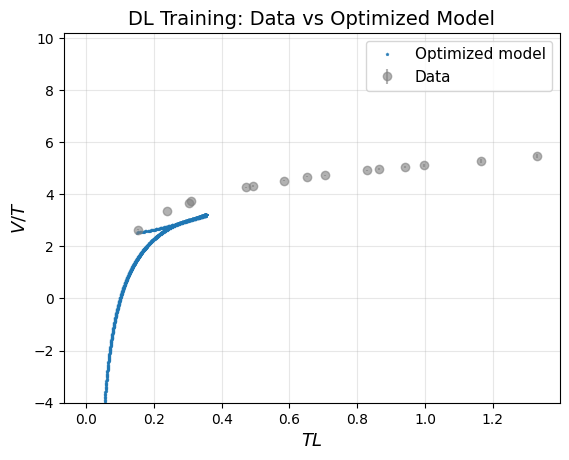

In [8]:
# Plot model vs data
with torch.no_grad():
    zs = torch.linspace(0.02, 0.99, 1000, dtype=dt, device=device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift 



# Left: Model vs data

plt.plot(Lc.cpu(), Vc.cpu(), 'p', markersize=1.5, label='Optimized model', alpha=0.8)
plt.errorbar(L_all.cpu(), V_all.real.cpu(), yerr=sigma_all.real.cpu(),
            fmt='o', markersize=6, alpha=0.6, label='Data', color='gray')
#plt.axvline(0.30, color='green', linestyle='--', alpha=0.5, label='Target L_max range')
#plt.axvline(0.60, color='green', linestyle='--', alpha=0.5)
plt.xlabel(r'$T L$', fontsize=13)
plt.ylabel(r'$V/T$', fontsize=13)
plt.ylim(-4, None)
plt.title('DL Training: Data vs Optimized Model', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()


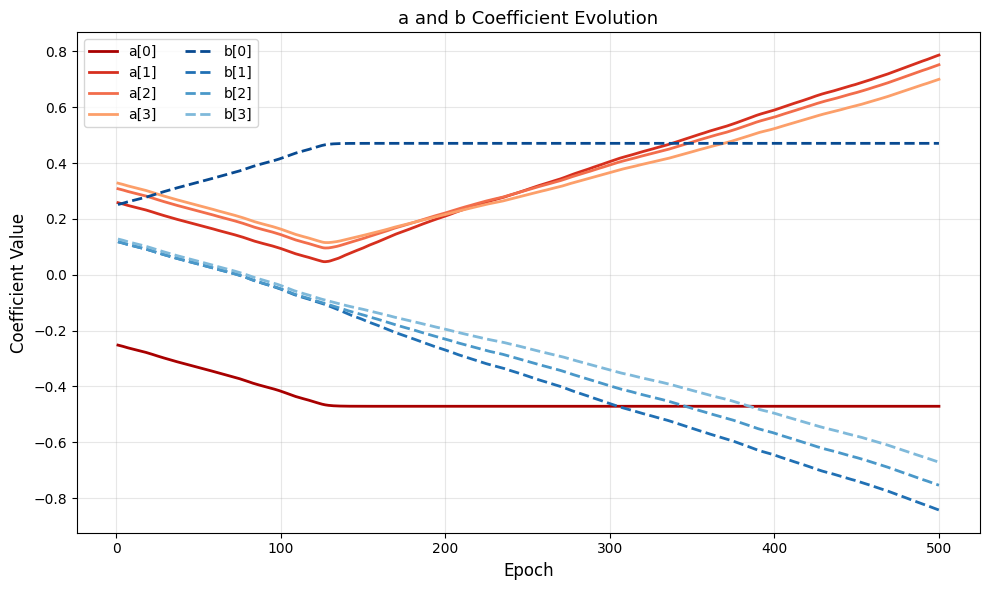

In [9]:
# Plot coefficient evolution
if len(a_hist) > 0:
    a_arr = np.stack(a_hist)
    b_arr = np.stack(b_hist)

    n_a = a_arr.shape[1]
    n_b = b_arr.shape[1]

    warm = plt.cm.OrRd(np.linspace(0.9, 0.45, n_a))
    cold = plt.cm.Blues(np.linspace(0.9, 0.45, n_b))

    plt.figure(figsize=(10, 6))
    epochs = np.arange(1, len(a_hist) + 1)

    for i in range(n_a):
        plt.plot(epochs, a_arr[:, i], color=warm[i], label=f'a[{i}]', linewidth=2)

    for i in range(n_b):
        plt.plot(epochs, b_arr[:, i], color=cold[i], linestyle='--', label=f'b[{i}]', linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.title('a and b Coefficient Evolution', fontsize=13)
    plt.legend(ncol=2, fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot - training may have failed")

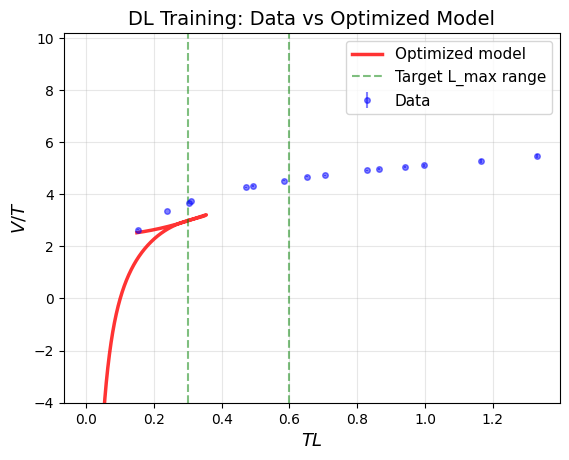

In [10]:
# Plot model vs data
with torch.no_grad():
    zs = torch.linspace(0.02, 0.99, 1000, dtype=dt, device=device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift


plt.plot(Lc.cpu(), Vc.cpu(), 'r-', linewidth=2.5, label='Optimized model', alpha=0.8)
plt.errorbar(L_all.cpu(), V_all.real.cpu(), yerr=sigma_all.real.cpu(),
            fmt='o', markersize=4, alpha=0.5, label='Data', color='blue')
plt.axvline(0.30, color='green', linestyle='--', alpha=0.5, label='Target L_max range')
plt.axvline(0.60, color='green', linestyle='--', alpha=0.5)
plt.xlabel(r'$T L$', fontsize=13)
plt.ylabel(r'$V/T$', fontsize=13)
plt.ylim(-4, None)
plt.title('DL Training: Data vs Optimized Model', fontsize=14)

plt.legend(fontsize=11)
plt.grid(alpha=0.3)

